In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Artem Oboturov(oboturov@gmail.com)                             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################
#######################################################################
# Copyright (C)                                                       #
# 2017 Cheung Auyeung (yellowlab9@gmail.com)                          #                        
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
figureIndex = 0

In [4]:
class Bandit:
    # @kArm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @stepSize: constant step size for updating estimations
    # @sampleAverages: if True, use sample averages to update estimations instead of constant step size
    # @UCB: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradientBaseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, kArm=10, epsilon=0., initial=0., stepSize=0.1, sampleAverages=False, UCBParam=None,
                 gradient=False, gradientBaseline=False, trueReward=0.):
        self.k = kArm
        self.stepSize = stepSize
        self.sampleAverages = sampleAverages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCBParam = UCBParam
        self.gradient = gradient
        self.gradientBaseline = gradientBaseline
        self.averageReward = 0
        self.trueReward = trueReward

        # real reward for each action
        self.qTrue = []

        # estimation for each action
        self.qEst = np.zeros(self.k)

        # # of chosen times for each action
        self.actionCount = []

        self.epsilon = epsilon

        # initialize real rewards with N(0,1) distribution and estimations with desired initial value
        for i in range(0, self.k):
            self.qTrue.append(np.random.randn() + trueReward)
            self.qEst[i] = initial
            self.actionCount.append(0)

        self.bestAction = np.argmax(self.qTrue)

    # get an action for this bandit, explore or exploit?
    def getAction(self):
        # explore
        if self.epsilon > 0:
            if np.random.binomial(1, self.epsilon) == 1:
                np.random.shuffle(self.indices)
                return self.indices[0]

        # exploit
        if self.UCBParam is not None:
            UCBEst = self.qEst + \
                     self.UCBParam * np.sqrt(np.log(self.time + 1) / (np.asarray(self.actionCount) + 1))
            return np.argmax(UCBEst)
        if self.gradient:
            expEst = np.exp(self.qEst)
            self.actionProb = expEst / np.sum(expEst)
            return np.random.choice(self.indices, p=self.actionProb)
        return np.argmax(self.qEst)

    # take an action, update estimation for this action
    def takeAction(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.qTrue[action]
        self.time += 1
        self.averageReward = (self.time - 1.0) / self.time * self.averageReward + reward / self.time
        self.actionCount[action] += 1

        if self.sampleAverages:
            # update estimation using sample averages
            self.qEst[action] += 1.0 / self.actionCount[action] * (reward - self.qEst[action])
        elif self.gradient:
            oneHot = np.zeros(self.k)
            oneHot[action] = 1
            if self.gradientBaseline:
                baseline = self.averageReward
            else:
                baseline = 0
            self.qEst = self.qEst + self.stepSize * (reward - baseline) * (oneHot - self.actionProb)
        else:
            # update estimation with constant step size
            self.qEst[action] += self.stepSize * (reward - self.qEst[action])
        return reward

In [5]:
def banditSimulation(nBandits, time, bandits):
    bestActionCounts = [np.zeros(time, dtype='float') for _ in range(0, len(bandits))]
    averageRewards = [np.zeros(time, dtype='float') for _ in range(0, len(bandits))]
    for banditInd, bandit in enumerate(bandits):
        for i in range(0, nBandits):
            for t in range(0, time):
                action = bandit[i].getAction()
                reward = bandit[i].takeAction(action)
                averageRewards[banditInd][t] += reward
                if action == bandit[i].bestAction:
                    bestActionCounts[banditInd][t] += 1
        bestActionCounts[banditInd] /= nBandits
        averageRewards[banditInd] /= nBandits
    return bestActionCounts, averageRewards

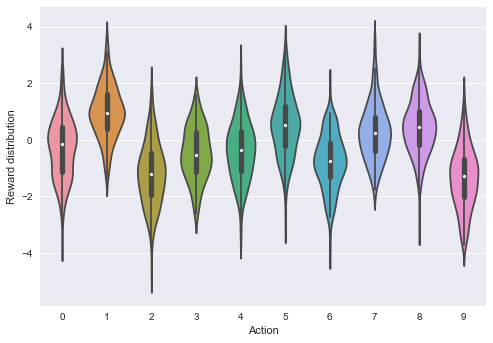

In [6]:
# for figure 2.1
def figure2_1():
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    sns.violinplot(data=np.random.randn(200,10) + np.random.randn(10))
    plt.xlabel("Action")
    plt.ylabel("Reward distribution")

figure2_1()
plt.show()

In [7]:
# for figure 2.2
def epsilonGreedy(nBandits, time):
    epsilons = [0, 0.1, 0.01]
    bandits = []
    for epsInd, eps in enumerate(epsilons):
        bandits.append([Bandit(epsilon=eps, sampleAverages=True) for _ in range(0, nBandits)])
    bestActionCounts, averageRewards = banditSimulation(nBandits, time, bandits)
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    for eps, counts in zip(epsilons, bestActionCounts):
        plt.plot(counts, label='epsilon = '+str(eps))
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.figure(figureIndex)
    figureIndex += 1
    for eps, rewards in zip(epsilons, averageRewards):
        plt.plot(rewards, label='epsilon = '+str(eps))
    plt.xlabel('Steps')
    plt.ylabel('average reward')
    plt.legend()

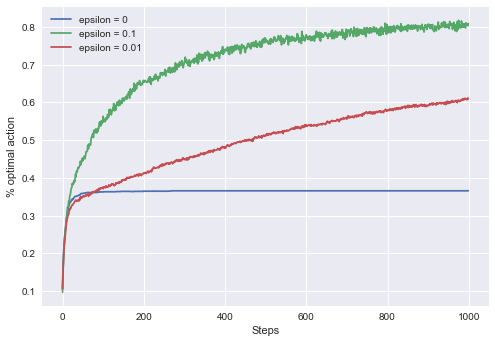

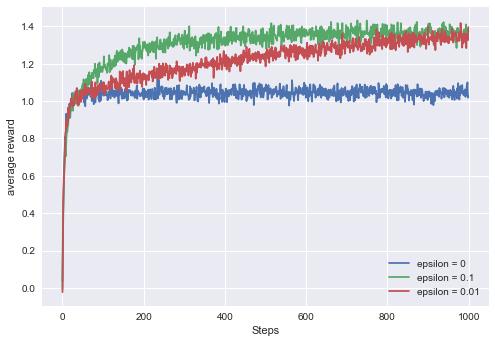

In [8]:
epsilonGreedy(2000, 1000)
plt.show()

In [9]:
# for figure 2.3
def optimisticInitialValues(nBandits, time):
    bandits = [[], []]
    bandits[0] = [Bandit(epsilon=0, initial=5, stepSize=0.1) for _ in range(0, nBandits)]
    bandits[1] = [Bandit(epsilon=0.1, initial=0, stepSize=0.1) for _ in range(0, nBandits)]
    bestActionCounts, _ = banditSimulation(nBandits, time, bandits)
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    plt.plot(bestActionCounts[0], label='epsilon = 0, q = 5')
    plt.plot(bestActionCounts[1], label='epsilon = 0.1, q = 0')
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()

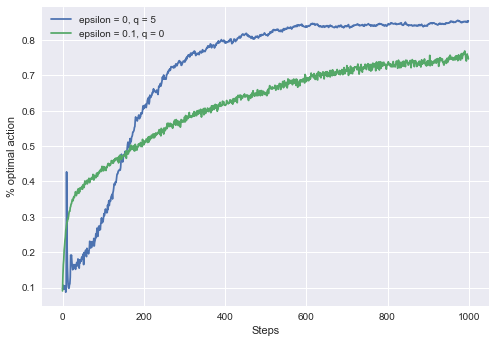

In [10]:
optimisticInitialValues(2000, 1000)
plt.show()

In [11]:
# for figure 2.4
def ucb(nBandits, time):
    bandits = [[], []]
    bandits[0] = [Bandit(epsilon=0, stepSize=0.1, UCBParam=2) for _ in range(0, nBandits)]
    bandits[1] = [Bandit(epsilon=0.1, stepSize=0.1) for _ in range(0, nBandits)]
    _, averageRewards = banditSimulation(nBandits, time, bandits)
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    plt.plot(averageRewards[0], label='UCB c = 2')
    plt.plot(averageRewards[1], label='epsilon greedy epsilon = 0.1')
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()

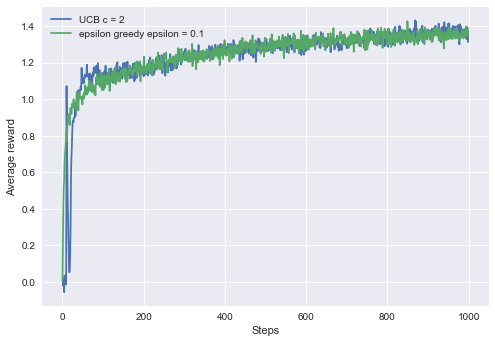

In [12]:
ucb(2000, 1000)
plt.show()

In [13]:
# for figure 2.5
def gradientBandit(nBandits, time):
    bandits =[[], [], [], []]
    bandits[0] = [Bandit(gradient=True, stepSize=0.1, gradientBaseline=True, trueReward=4) for _ in range(0, nBandits)]
    bandits[1] = [Bandit(gradient=True, stepSize=0.1, gradientBaseline=False, trueReward=4) for _ in range(0, nBandits)]
    bandits[2] = [Bandit(gradient=True, stepSize=0.4, gradientBaseline=True, trueReward=4) for _ in range(0, nBandits)]
    bandits[3] = [Bandit(gradient=True, stepSize=0.4, gradientBaseline=False, trueReward=4) for _ in range(0, nBandits)]
    bestActionCounts, _ = banditSimulation(nBandits, time, bandits)
    labels = ['alpha = 0.1, with baseline',
              'alpha = 0.1, without baseline',
              'alpha = 0.4, with baseline',
              'alpha = 0.4, without baseline']
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    for i in range(0, len(bandits)):
        plt.plot(bestActionCounts[i], label=labels[i])
    plt.xlabel('Steps')
    plt.ylabel('% Optimal action')
    plt.legend()

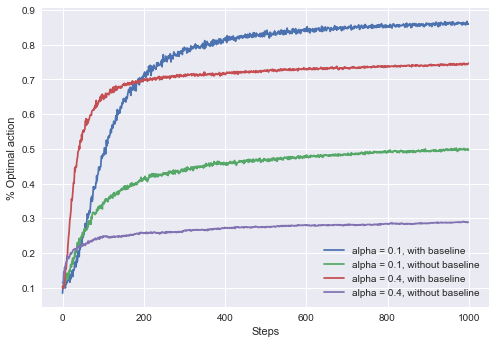

In [14]:
# This will take somehow a long time
gradientBandit(2000, 1000)
plt.show()

In [17]:
# Figure 2.6
def figure2_6(nBandits, time):
    labels = ['epsilon-greedy', 'gradient bandit',
              'UCB', 'optimistic initialization']
    generators = [lambda epsilon: Bandit(epsilon=epsilon, sampleAverages=True),
                  lambda alpha: Bandit(gradient=True, stepSize=alpha, gradientBaseline=True),
                  lambda coef: Bandit(epsilon=0, stepSize=0.1, UCBParam=coef),
                  lambda initial: Bandit(epsilon=0, initial=initial, stepSize=0.1)]
    parameters = [np.arange(-7, -1),
                  np.arange(-5, 2),
                  np.arange(-4, 3),
                  np.arange(-2, 3)]

    bandits = [[generator(pow(2, param)) for _ in range(0, nBandits)] for generator, parameter in zip(generators, parameters) for param in parameter]
    _, averageRewards = banditSimulation(nBandits, time, bandits)
    rewards = np.sum(averageRewards, axis=1)/time

    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    i = 0
    for label, parameter in zip(labels, parameters):
        l = len(parameter)
        plt.plot(parameter, rewards[i:i+l], label=label)
        i += l
    plt.xlabel('Parameter(2^x)')
    plt.ylabel('Average reward')
    plt.legend()

In [18]:
# This will take somehow a long time
figure2_6(2000, 1000)
plt.show()

ValueError: Integers to negative integer powers are not allowed.